# SARPy Demo

![test](SARPy_logo.png)

In [7]:
%pip install "sarpy[all] @ git+https://github.com/ngageoint/sarpy.git@integration/1.3.59-rc"

  Cloning https://github.com/ngageoint/sarpy.git (to revision integration/1.3.59-rc) to /data/tmp/pip-install-7q7o7m0o/sarpy_c418576de35f40c8855f2a1358df69ce
  Running command git clone --filter=blob:none --quiet https://github.com/ngageoint/sarpy.git /data/tmp/pip-install-7q7o7m0o/sarpy_c418576de35f40c8855f2a1358df69ce
  Running command git checkout -b integration/1.3.59-rc --track origin/integration/1.3.59-rc
  Switched to a new branch 'integration/1.3.59-rc'
  branch 'integration/1.3.59-rc' set up to track 'origin/integration/1.3.59-rc'.
  Resolved https://github.com/ngageoint/sarpy.git to commit cf5533bbeea219d859df43c32db70a5be19406c9
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [8]:
%matplotlib inline

import pathlib
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import smart_open

import sarpy
import sarpy.consistency.cphd_consistency
import sarpy.consistency.sicd_consistency
import sarpy.geometry.point_projection
import sarpy.io.complex
import sarpy.io.phase_history.cphd


print(sarpy.__version__)

1.3.59rc


GeoDataType: ValidData entry 0 is not contained ImageCorners.
	**disregard if crosses the +/-180 boundary
GeoDataType: ValidData entry 1 is not contained ImageCorners.
	**disregard if crosses the +/-180 boundary
GeoDataType: ValidData entry 2 is not contained ImageCorners.
	**disregard if crosses the +/-180 boundary
GeoDataType: ValidData entry 3 is not contained ImageCorners.
	**disregard if crosses the +/-180 boundary
RadiometricType: No Radiometric.NoiseLevel provided, so noise estimates will not be possible.
SICDType: No Timeline.IPP provided, so no PRF/PRI available for analysis of ambiguities.


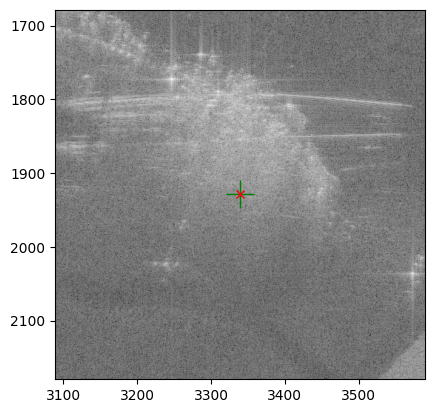

In [9]:
with smart_open.open("https://six-library-github-public.s3.us-east-2.amazonaws.com/sicd_example_1_PFA_RE32F_IM32F_HH.nitf", mode='rb') as f:
    sicd = sarpy.io.complex.open(f)
    sicd.sicd_meta.is_valid(recursive=True)

    scp_row, scp_col = sicd.sicd_meta.ImageData.SCPPixel.get_array()
    projected_scp, _, _ = sicd.sicd_meta.project_ground_to_image(sicd.sicd_meta.GeoData.SCP.ECF.get_array())
    min_row, max_row = map(int, scp_row + np.array([-250, 250]))
    min_col, max_col = map(int, scp_col + np.array([-250, 250]))
    plt.imshow(np.log10(np.abs(sicd[min_row:max_row, min_col:max_col])), cmap="gray",
               extent=[min_col-0.5, max_col+0.5, max_row+0.5, min_row-0.5])
    plt.plot(scp_col, scp_row, "g+", markersize=20)
    plt.plot(projected_scp[1], projected_scp[0], "rx")
    plt.show()

In [10]:
with smart_open.open("https://capella-open-data.s3.amazonaws.com/data/2023/9/29/CAPELLA_C11_SP_CPHD_HH_20230929120708_20230929120738/CAPELLA_C11_SP_CPHD_HH_20230929120708_20230929120738.cphd", mode='rb') as f:
    cphd = sarpy.io.phase_history.cphd.CPHDDetails(f)

with tempfile.TemporaryDirectory() as tmpdir:
    cphd_xml_file = pathlib.Path(tmpdir) / 'cphd.xml'
    cphd_xml_file.write_bytes(cphd.cphd_meta.to_xml_bytes())
    sarpy.consistency.cphd_consistency.main([
        str(cphd_xml_file),
        '-vvv',
        '--signal-data',
    ])

check_against_schema: The XML matches the schema.
    [Error] Need: XML passes schema
        line#378: assert schema.validate(self.xml_with_ns), schema.error_log
        <string>:1:0:ERROR:SCHEMASV:SCHEMAV_CVC_MININCLUSIVE_VALID: Element
            '{http://api.nsgreg.nga.mil/schema/cphd/1.1.0}TxTime1': [facet 'minInclusive'] The value
            '-7.33841009435934552E-09' is less than the minimum value allowed ('0').
        assert False
         +  where False = <bound method _Validator.validate of <lxml.etree.XMLSchema object at 0x7fda63c93380>>(<Element
            {http://api.nsgreg.nga.mil/schema/cphd/1.1.0}CPHD at 0x7fda62d32dc0>)
         +    where <bound method _Validator.validate of <lxml.etree.XMLSchema object at 0x7fda63c93380>> =
            <lxml.etree.XMLSchema object at 0x7fda63c93380>.validate
         +    and   <Element {http://api.nsgreg.nga.mil/schema/cphd/1.1.0}CPHD at 0x7fda62d32dc0> = <CphdConsistency
            object at 0x7fda1799acd0>.xml_with_ns
    [Pa

In [11]:
%pip install "sarpy-apps"

Note: you may need to restart the kernel to use updated packages.


In [12]:
import sarpy.io.phase_history
from sarpy_apps.supporting_classes import cphd_plotting
with smart_open.open("https://capella-open-data.s3.amazonaws.com/data/2023/9/29/CAPELLA_C11_SP_CPHD_HH_20230929120708_20230929120738/CAPELLA_C11_SP_CPHD_HH_20230929120708_20230929120738.cphd", mode='rb') as f:
    cphd_details = sarpy.io.phase_history.cphd.CPHDDetails(f)
    cphd = sarpy.io.phase_history.cphd.CPHDReader1.__new__(sarpy.io.phase_history.cphd.CPHDReader1)
    cphd._cphd_meta = cphd_details.cphd_meta
    cphd._cphd_details = cphd_details

    pvp_dtype = cphd.cphd_meta.PVP.get_vector_dtype()
    cphd._pvp_memmap = dict()
    cphd._channel_map = dict()
    for i, entry in enumerate(cphd.cphd_meta.Data.Channels):
        cphd._channel_map[entry.Identifier] = i
        offset = cphd.cphd_header.PVP_BLOCK_BYTE_OFFSET + entry.PVPArrayByteOffset
        shape = (entry.NumVectors, )
        f.seek(offset, 0)
        buffer = f.read(cphd.cphd_meta.Data.NumBytesPVP * shape[0])
        indices = np.rint(np.linspace(0, entry.NumVectors-1, 51, endpoint=True)).astype(int)
        cphd._pvp_memmap[entry.Identifier] = np.frombuffer(buffer, dtype=pvp_dtype)[indices]

    fig = cphd_plotting.plot_image_area(cphd)

In [13]:
fig.show()